In [5]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [6]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return allsubs

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['age', 'sex', 'wrat'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest', 'nback', 'emoid'], subs)
print(X[0].shape)

830
(830, 264, 124)


In [7]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 1.83

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [0.01, 0.2], 1/tr)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

p = [np.stack([ts_to_flat_fc(ts) for ts in filter_design_ts(Xp)]) for Xp in X]
# ts = [tsmod/np.linalg.norm(tsmod, axis=(-1), keepdims=True) for tsmod in ts]
print(p.shape)

AttributeError: 'list' object has no attribute 'shape'

In [8]:
p[0].shape

(830, 34716)

In [24]:
odir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/test/fc'

for i in range(10):
    fname = f'{odir}/{i:03}_task-rest_fc'
    np.save(fname, p[0][i], allow_pickle=False)
    
print('Complete')

Complete


In [16]:
(1+(1+8*34716)**0.5)/2

264.0

34716


NameError: name 'io' is not defined

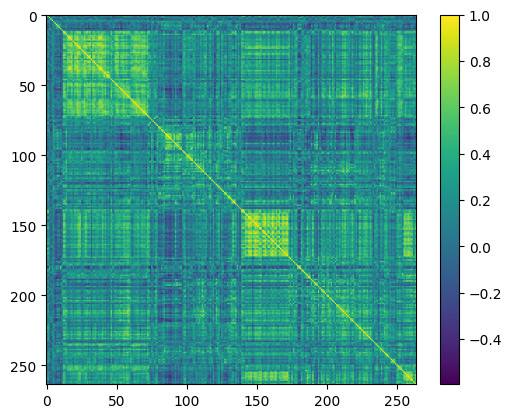

In [31]:
fc = np.load(fname+'.npy')

import matplotlib.pyplot as plt

def fcvec2mat(fc):
    n = len(fc)
    d = int(round((1+(1+8*n)**0.5)/2))
    a,b = np.triu_indices(d,1)
    mat = np.zeros((d,d))
    mat[a,b] = fc
    mat += mat.T
    ones = np.arange(d)
    mat[ones,ones] = 1
    return mat

def imshow(fc, colorbar=True):
    fc = fcvec2mat(fc)
    fig, ax = plt.subplots()
    im = ax.imshow(fc)
    if colorbar:
        fig.colorbar(mappable=im, ax=ax)
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    return base64.b64encode(buf.read()).decode()

print(len(fc))
imshow(fc)

In [3]:
type(list(metadict['age'].keys())[0])

int

In [16]:
fname = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/test/demographics.pkl'

tasks = ['age', 'sex', 'wrat']
demo = {task: {} for task in tasks}
subs_list = list(subs)

for i in range(10):
    for task in tasks:
        demo[task][f'{i:03}'] = metadict[task][subs_list[i]]

with open(fname, 'wb') as f:
    pickle.dump(demo, f)
    
print('Complete')

Complete
